In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
# # NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
#     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#     #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

# print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Split Train & Testing folder

In [ ]:
path = '/kaggle/input/images-of-fire-and-corresponding-masking-results/Fire/image'
all_files = os.listdir(path)
all_files = [i.split('_')[1] for i in all_files]

n_test = int( 0.2*len(all_files))

test_files = all_files[:n_test]
train_files = all_files[n_test:]

# Preprocess and Prepare Data

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_name = 'image_'+id_name
        mask_name = 'mask_'+id_name
        image_path = os.path.join("/kaggle/input/images-of-fire-and-corresponding-masking-results/Fire/image/", image_name)
        mask_path = os.path.join("/kaggle/input/images-of-fire-and-corresponding-masking-results/Fire/mask/", mask_name)
        # image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        # mask_path = os.path.join(self.path, id_name, "masks/")
        # all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ## Reading Masks
        # for name in all_masks:
        #     _mask_path = mask_path + name
        #     _mask_image = cv2.imread(_mask_path, -1)
        #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        #     _mask_image = np.expand_dims(_mask_image, axis=-1)
        
        _mask_image = cv2.imread(mask_path)
        _mask_image =cv2.cvtColor(_mask_image,cv2.COLOR_BGR2GRAY)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
        _mask_image = np.expand_dims(_mask_image, axis=-1)
            
        ## Normalizing 
        image = image/255.0
        mask = _mask_image/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

preprocessing: 
- train test split
- konversi BGR jadi RGB
- resize jadi 128
- expand dimension

In [ ]:
# image_size = 64
image_size = 128
train_path = "/kaggle/input/images-of-fire-and-corresponding-masking-results/Fire/image"
epochs = 1
# epochs = 10
batch_size = 10

## Training Ids
# train_ids = next(os.walk(train_path))[2]
# train_ids = [i.split('_')[1] for i in train_ids]

## Validation Data Size
val_data_size = 100




# Separating fire and non-fire images

## Load classifier

In [ ]:
from tensorflow.keras.models import Sequential,load_model
model = load_model('/kaggle/input/fire-detector/fire_detection.h5')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_20 (Separa  (None, 128, 128, 16)     211       
 bleConv2D)                                                      
                                                                 
 activation_35 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_30 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_21 (Separa  (None, 64, 64, 32)       688       
 bleConv2D)                                           

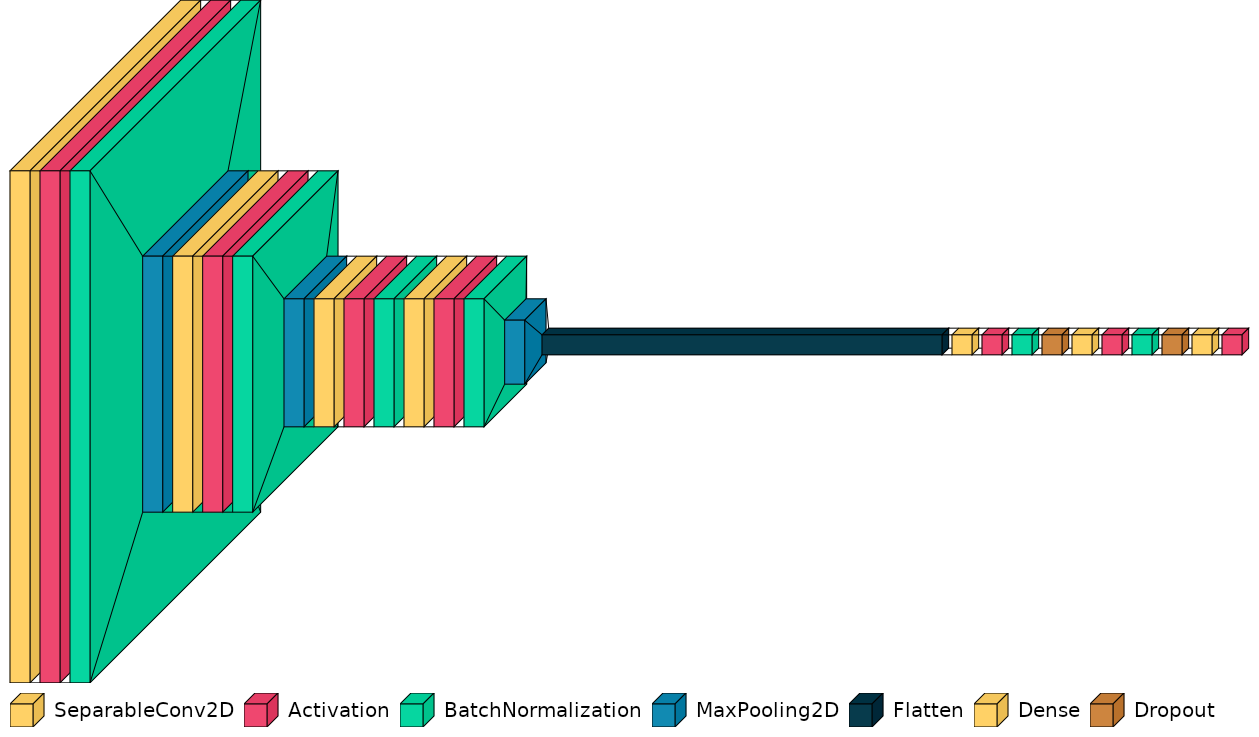

In [ ]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont

fontname = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf' # Linux
font = ImageFont.truetype(fontname, 20) if os.path.isfile(fontname) else ImageFont.load_default()

cmap = defaultdict(dict)
cmap[tf.keras.layers.Dropout]['fill'] = 'peru'

visualkeras.layered_view(model, legend=True, color_map=cmap, font = font)

In [ ]:
valid_ids = train_files[:val_data_size]
train_ids = train_files[val_data_size:]

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(10, 128, 128, 3) (10, 128, 128, 1)


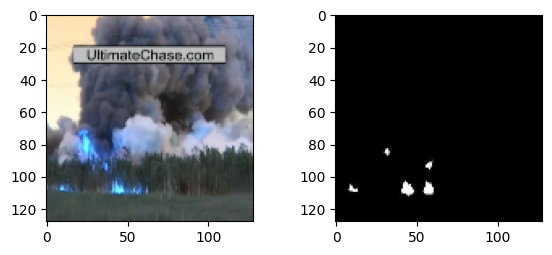

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# Segmentation

## Defining U-Net Architecture

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((128, 128, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

## Visualize Model

In [ ]:
!pip install visualkeras


In [ ]:
import visualkeras
from collections import defaultdict

color_map = defaultdict(dict)
color_map[tf.keras.layers.InputLayer]['fill'] = 'gray'

color_map[tf.keras.layers.Conv2D]['fill'] = 'gold'

color_map[tf.keras.layers.Conv2DTranspose]['fill'] = 'plum'
color_map[tf.keras.layers.ZeroPadding2D]['fill'] = 'gray'
color_map[tf.keras.layers.Dropout]['fill'] = 'pink'
color_map[tf.keras.layers.MaxPooling2D]['fill'] = 'steelblue'
color_map[tf.keras.layers.Dense]['fill'] = 'green'
color_map[tf.keras.layers.Flatten]['fill'] = 'teal'

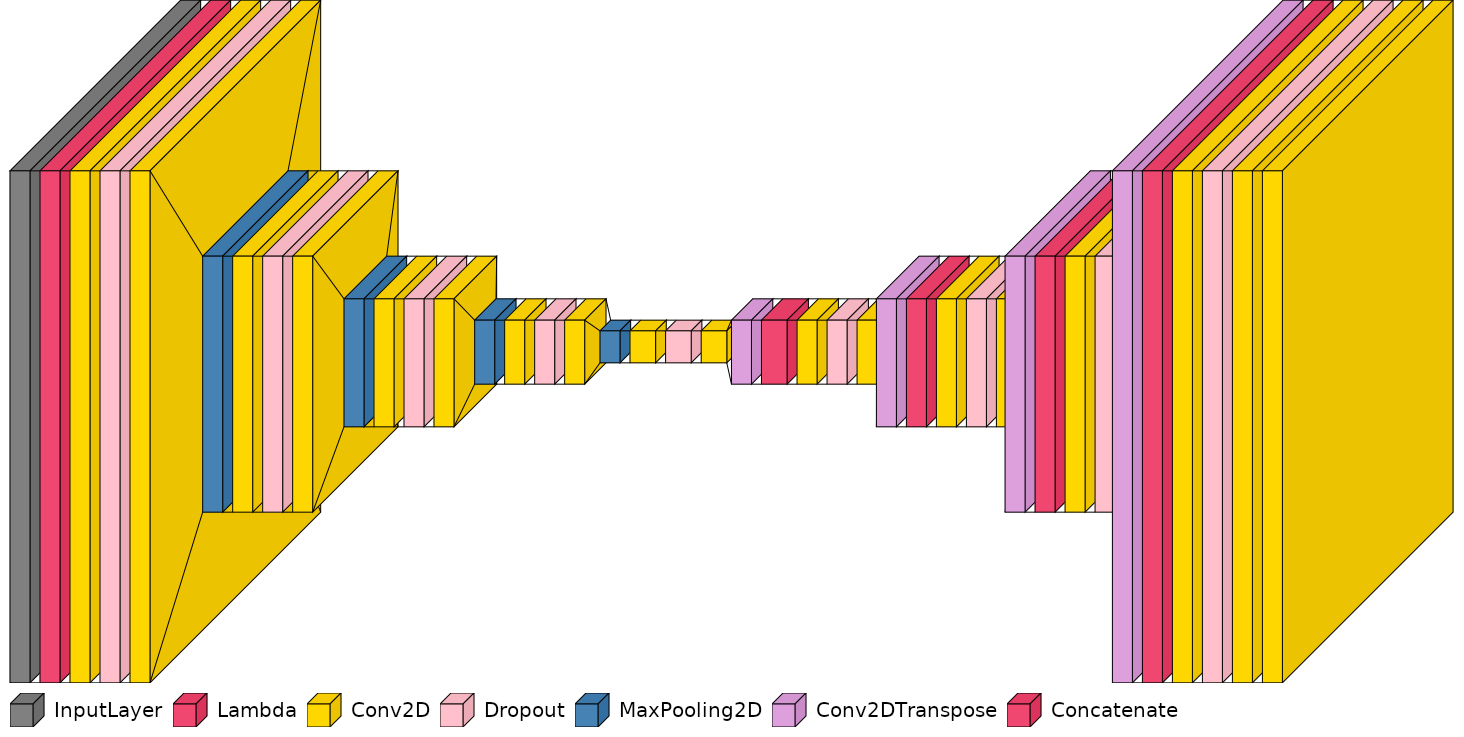

In [ ]:
from PIL import ImageFont

fontname = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf' # Linux
font = ImageFont.truetype(fontname, 20) if os.path.isfile(fontname) else ImageFont.load_default()

visualkeras.layered_view(model, legend=True, color_map=color_map, font = font)

In [ ]:
tf.keras.utils.plot_model(model)


# Train model

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.compile(optimizer='rmsprop', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryIoU(), 'accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)
hist1=model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=70, callbacks= [early_stop,reduce_lr_on_plateau])

Epoch 1/70


2023-06-02 06:30:56.318253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


204/204 [==============================] - 18s 63ms/step - loss: 0.2254 - binary_io_u_2: 0.4842 - accuracy: 0.9266 - val_loss: 0.1894 - val_binary_io_u_2: 0.4821 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 2/70
204/204 [==============================] - 11s 55ms/step - loss: 0.1614 - binary_io_u_2: 0.4855 - accuracy: 0.9284 - val_loss: 0.2162 - val_binary_io_u_2: 0.4821 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 3/70
204/204 [==============================] - 11s 53ms/step - loss: 0.1166 - binary_io_u_2: 0.6590 - accuracy: 0.9356 - val_loss: 0.1005 - val_binary_io_u_2: 0.7204 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 4/70
204/204 [==============================] - 11s 54ms/step - loss: 0.0832 - binary_io_u_2: 0.7367 - accuracy: 0.9460 - val_loss: 0.0751 - val_binary_io_u_2: 0.7472 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/70
204/204 [==============================] - 11s 53ms/step - loss: 0.0669 - binary_io_u_2: 0.7546 - accuracy: 0.9492 - val_loss: 0.0685 - val_binary_io_u_2: 0.7900 - 

In [ ]:
hist1.history.keys()

dict_keys(['loss', 'binary_io_u_2', 'accuracy', 'val_loss', 'val_binary_io_u_2', 'val_accuracy', 'lr'])

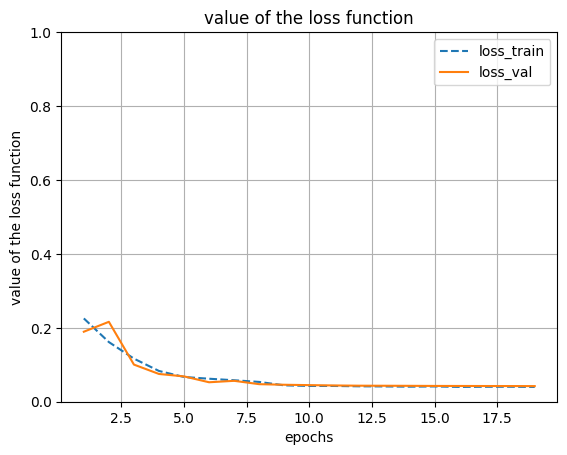

In [ ]:
loss = hist1.history['loss']
loss_val = hist1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, '--', label='loss_train')
plt.plot(epochs, loss_val, '-', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.ylim(0, 1)

plt.legend()
plt.grid()
plt.show()

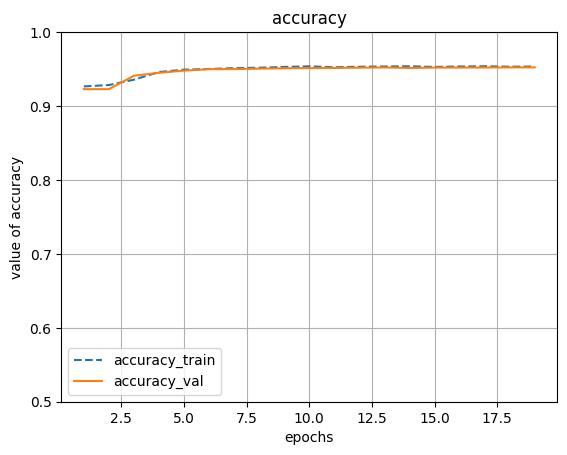

In [ ]:
acc = hist1.history['accuracy']
acc_val = hist1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, '--', label='accuracy_train')
plt.plot(epochs, acc_val, '-', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.show()

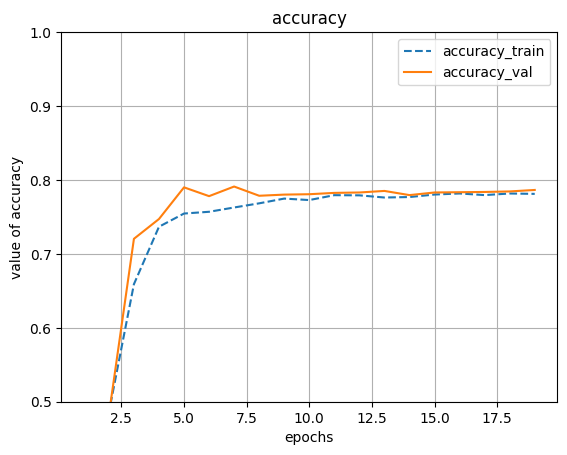

In [ ]:
acc = hist1.history['binary_io_u_2']
acc_val = hist1.history['val_binary_io_u_2']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, '--', label='accuracy_train')
plt.plot(epochs, acc_val, '-', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
## Save the Weights
model.save_weights("unet spot the fire 20 epochs.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 257ms/step


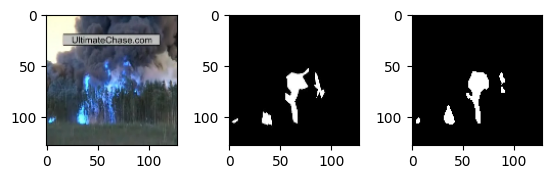

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

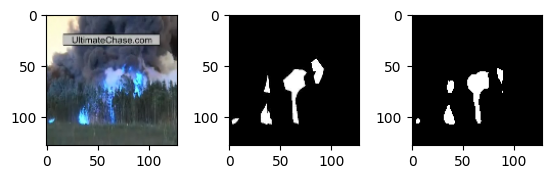

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[3])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[3]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[3]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[6])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[6]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[6]*255, (image_size, image_size)), cmap="gray")

# Evaluate

In [ ]:
test_gen = DataGen(test_files, train_path, image_size=image_size, batch_size=batch_size)
test_steps = (len(test_files)//batch_size)
model.evaluate(test_gen, steps=test_steps)

